# Modelos Generativos a través de autoencoders.
Los siguientes pasos muestran como generar objetos nuevos (nuevos datos) con autoencoders.

* Defina los objetos que se quieren generar. Gatos, perros (imágenes), música, poesía (texto). Obtenga para entrenar.

* Entrenar el modelo y obtener los pesos.

* Muestreamos los puntos (para datos nuevos) en el espacio latente (latent space). Vamos a ver como, más adelante.

* Usando los pesos aprendidos, entonces generar los nuevos datos. (nuevos gatos, o perros, o poesía, o música, etc).

Como anuncié en la clase anterior, y antes de generar nuevos datos, vamos a ver como usar autoencoders para eliminar ruido y para detección de anomalía.

La agenda para hoy es:
* Eliminación de ruido usando autoencoders.
* Detección de anomalías usando autoencoders.
* Generación de nuevos datos: **variational autoencoders**.


## Eliminación de ruido con autoencoders.
* No se necesita una funcion de penalización por que el mismo ruido actúa como regularizador.

El proceso para diseñar y probar el algoritmo es:
* Tomamos datos limpios (el MNIST).
* Agregamos ruido a los datos.
* Se construye la red.
* Usamos como función de costo la diferencia entre los datos con y sin  ruido
$$J = \| x - \hat{x} \|² $$
donde $x$ son los datos sin ruido y $\hat{x}$ son los datos con ruido.
Una vez hacemos el "encoding" (codificación) es
$z= f(x + N)$ donde $N$ es el ruido, $f$ es el codificador.
El decodificador es $\hat{x} = g(z) = g (f ( x + N))$.

Escribimos un programa en `Python` para esto.

In [2]:
#  eliminación de ruido usando autoencoders.
# importar librerías
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Flatten, Reshape
from keras.layers import Conv2D, UpSampling2D, MaxPooling2D
from keras.models import Model
from keras import regularizers

In [3]:
# librería para graficar el modelo
from tensorflow.keras.utils import plot_model

In [4]:
# seed to reproduce results
np.random.seed(42)

# load MNIST data
(x_train, _), (x_test, _) = mnist.load_data()

# normalize MNIST data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# reshape to include the channel dimension
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# add random noise to the images
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# clip the values to be between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)



In [5]:
# set the autoencoder
input_img = Input(shape=(28, 28, 1))

# convolutional model
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
# MaxPooling
x = MaxPooling2D((2, 2), padding='same')(x)
# convolutional layer
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# MaxPooling
encoded = MaxPooling2D((2, 2), padding='same')(x)

# define the decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
# one more conv2d and upsampling2d
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
# decoded conv2d
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# el modelo autoencoder
autoencoder = Model(input_img, decoded)

# compile the model
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


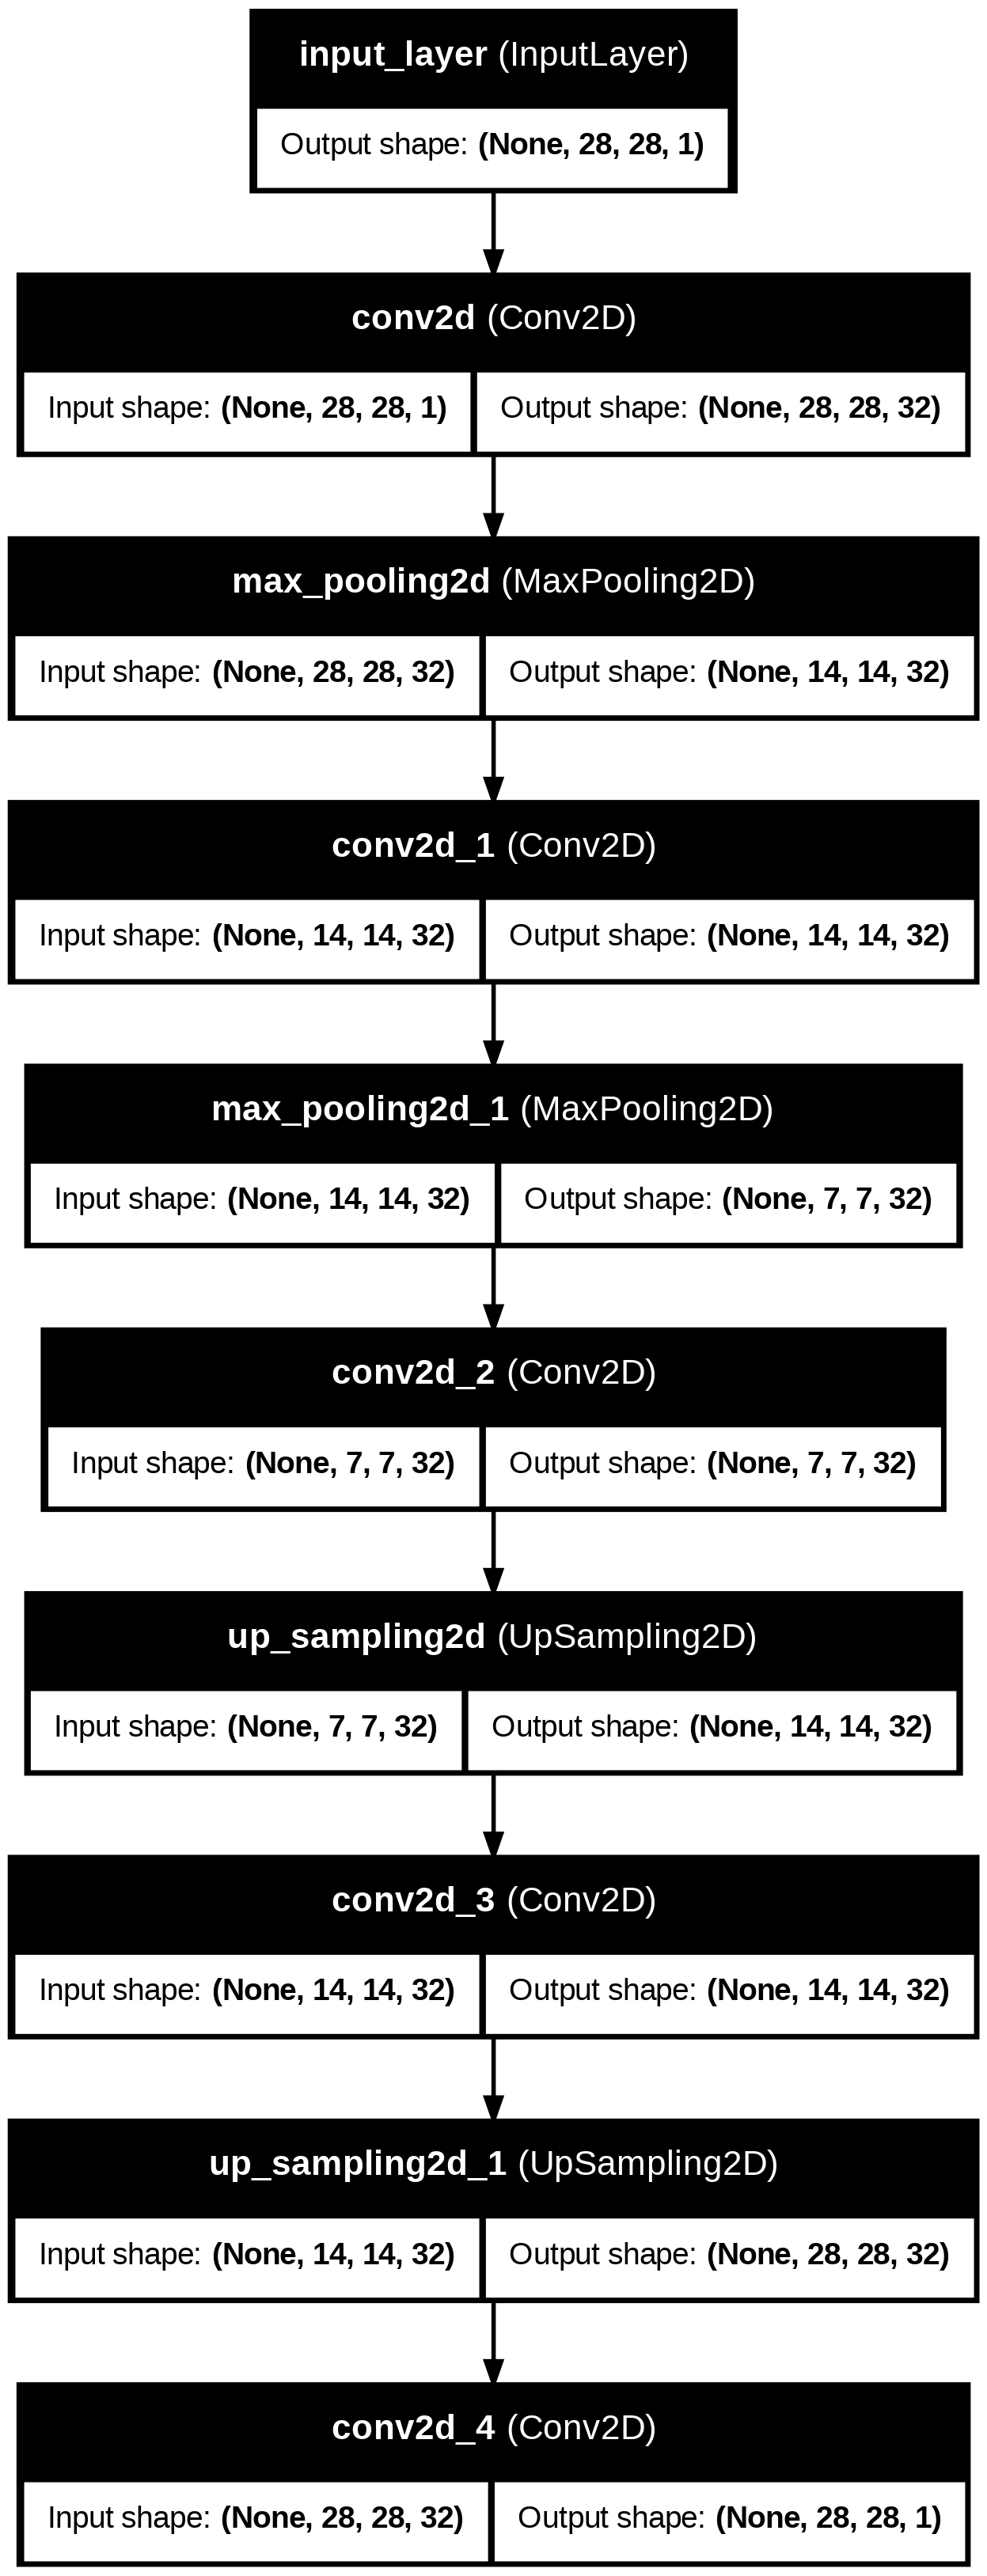

In [6]:
# plot the model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True, show_layer_names=True)

In [7]:
# train the model
autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.7189 - val_loss: 0.7012
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.6948 - val_loss: 0.6721
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.6591 - val_loss: 0.6041
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5775 - val_loss: 0.5228
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5142 - val_loss: 0.5084
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5026 - val_loss: 0.5005
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.4949 - val_loss: 0.4925
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4869 - val_loss: 0.4844
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4785 - val_loss: 0.4763
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4706 - val_loss: 0.4675
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.4620 - val_loss: 0.4580
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/st

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


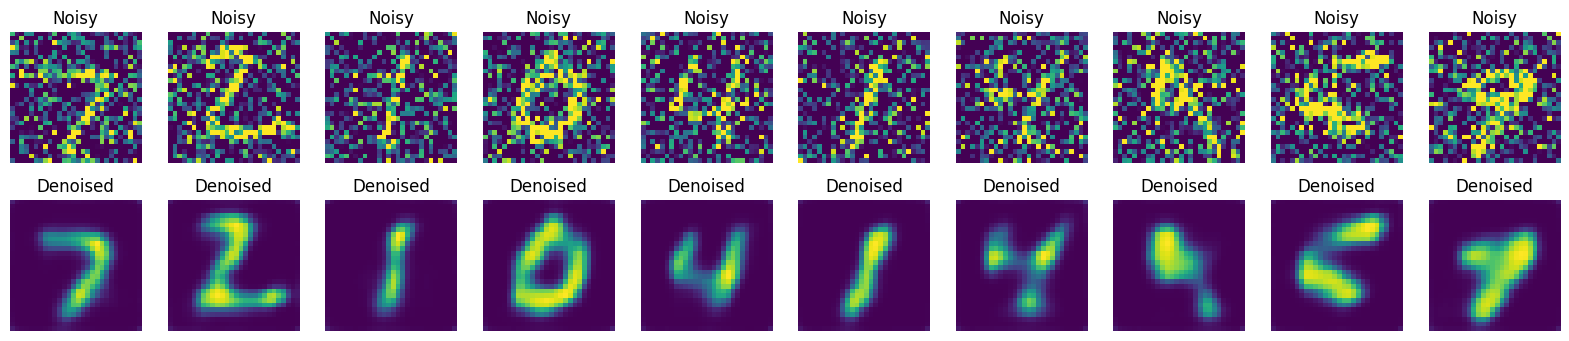

In [8]:
# predict the denoised images
decoded_imgs = autoencoder.predict(x_test_noisy)

# plot the results
n=10 # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    # plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.title("Noisy")
    plt.axis("off")

    # display denoised data
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    # plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    plt.axis("off")
plt.show()

# Detección de anomalías con auto-encoders.
Hay dos sitios buenos para este tema
[Anomaly detection with Auto-Encoders blog](https://www.kaggle.com/code/robinteuwens/anomaly-detection-with-auto-encoders) y
[Desmystitying  Neural Networks: Anomaly detection with AutoEncoders](https://medium.com/@weidagang/demystifying-anomaly-detection-with-autoencoder-neural-networks-1e235840d879).

El código del último enlace es con MLP. Sin embargo acá vamos a usar Conv2D, pues usamos el MNIST.

En las notas de clase "0" es el normal y los dígitos del 1 al 9 son anomalías.  Esto no es lo usual. Lo usual es que las anomalías son menos. Entonces voy a modificar el código de las notas donde la anomalía es 0.







In [14]:
# load library for mnist data
from tensorflow.keras.datasets import mnist
import numpy as np
# load and prepare data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# normalize data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# reshape data to include channel dimensions
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [15]:
# use digit '0' as normal data
x_train_normal = x_train[y_train != 0]
x_test_normal = x_test[y_test != 0]

# use other digits as anomalies
x_train_anomalies = x_train[y_train == 0]
x_test_anomalies = x_test[y_test == 0]

In [16]:
# load libraries
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
# anomaly detection with autoencoders
# data is downloaeed and librarires uploaded
input_img = Input(shape=(28, 28, 1))

# define encoder
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

# define decoder
x = Conv2D(32, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

# define the autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [17]:
# train the autoencoder
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.2587 - val_loss: 0.0828
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0807 - val_loss: 0.0755
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0757 - val_loss: 0.0730
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0732 - val_loss: 0.0715
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0720 - val_loss: 0.0702
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0708 - val_loss: 0.0695
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0701 - val_loss: 0.0690
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0694 - val_loss: 0.0684
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0687 - val_loss: 0.0680
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0684 - val_loss: 0.0676
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0680 - val_loss: 0.0675
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10

282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


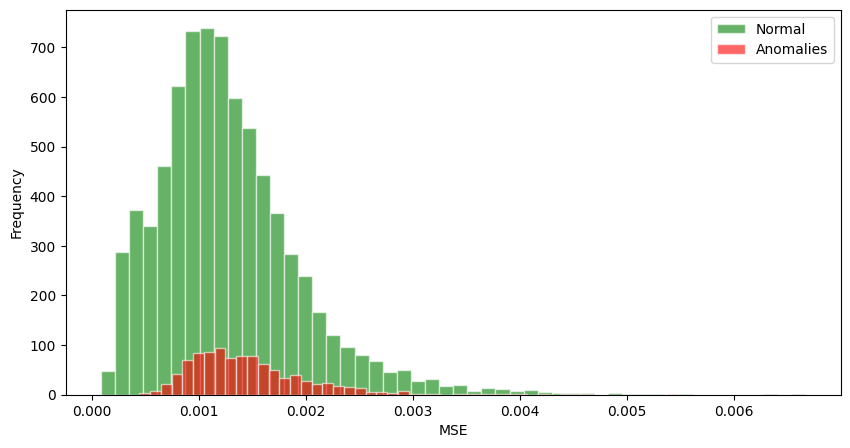

Threshold: 0.0032854727
Anomalies: 13


In [22]:
# evaluar y detectar anomalías
decoded_normal = autoencoder.predict(x_test_normal)
decoded_anomalies = autoencoder.predict(x_test_anomalies)

# calcular el error de la reconstrucción
mse_normal = np.mean(np.square(x_test_normal - decoded_normal), axis=(1,2,3))
mse_anomalies = np.mean(np.square(x_test_anomalies - decoded_anomalies), axis=(1,2,3))

# make figura
fig, ax = plt.subplots(figsize=(10,5))

# make histograms
ax.hist(mse_normal, bins=50, density=True, color='g', alpha=0.6, edgecolor='w', label='Normal')
ax.hist(mse_anomalies, bins=50, color='r', alpha=0.6, edgecolor='w', label='Anomalies')
ax.legend()
ax.set_xlabel('MSE')
ax.set_ylabel('Frequency')
plt.show()

# set threshold for anomaly detection
threshold = np.mean(mse_normal) + 3*np.std(mse_normal)

# detect anomalies
anomaly_mask = mse_anomalies > threshold

# print threshold and anomalies
print('Threshold:', threshold)
print('Anomalies:', np.sum(anomaly_mask))

# Variational auto-encoders.
Mientras los "vanilla" auto-encoders (son los que hemos visto) se pueden usar para generar (generativos) pero no son muy adecuados. Entonces aparecen los **variational autoencoders**, son metodos **Bayesians**. Usan estadística.



Bibliografía: Este tema lo introdujeron Kingma and Welling
[42] Diederik P. Kingma and Max Welling. Auto-Encoding Variational Bayes, 2014. https:
//arxiv.org/abs/1312.6114.

También en 2019:
[43] Diederik P. Kingma and Max Welling. An introduction to variational autoencoders.
Foundations and Trends® in Machine Learning, 12(4):307–392, 2019.

La generación de datos nuevos (imágenes, poesía, mústica, etc) se hace a partir del espacio latente. Se toma una muestra en el espacio latente y se calcula la salida. Esa muestra es aleatoria. Si la muestra corresponde a un objeto de salida la reproducción es exacta, sino, toca interpolar esta muestra entre objetos de salida. Explico en la siguiente gráfica.

Hay desventajas con los autoencoders "de vainlla".
* El espacio latente no es simétrico con respecto al origen. La siguiente figura ilustra esto. Esta desventaja se ve más clara un poco más adelante. En los autoencoders variacionales el espacio latene se transforma a una distribución normal

$$z = \mathcal{N}(0, I) $$

* Los huecos en el autoencoder de vainlilla generan objetos que no son claramente distinguibles. Por ejemplo el hueco en la figura entre el 6 y el 7 nos deja la pregunta de que dígito se va generar.  Toca hacer interpolación.

Para subsanar estos problemas se usa estadística.
* El muestreo (sampling) se hace a partir del espacio latente mediante una Gaussiana $z =\mathcal{N}(0, I) $
* Interpolación es suave.
* Usamos argumentos Bayesianos y de verosimilitud.
* Se subsanan las discontinuidades en el espacio latente con estas interpolaciones.

En resumen, los VAE (Variational Auto-Encoders) combinan las ideas de la estadística Bayesian con el Deep Learning

[57] Kevin P. Murphy. Machine Learning: A Probabilistic Perspective. MIT Press, Cam-
bridge, MA, USA, 2012.

El enlace
[Jeremy Jordan](https://www.jeremyjordan.me/variational-autoencoders/) es bastantte bueno en el tema.






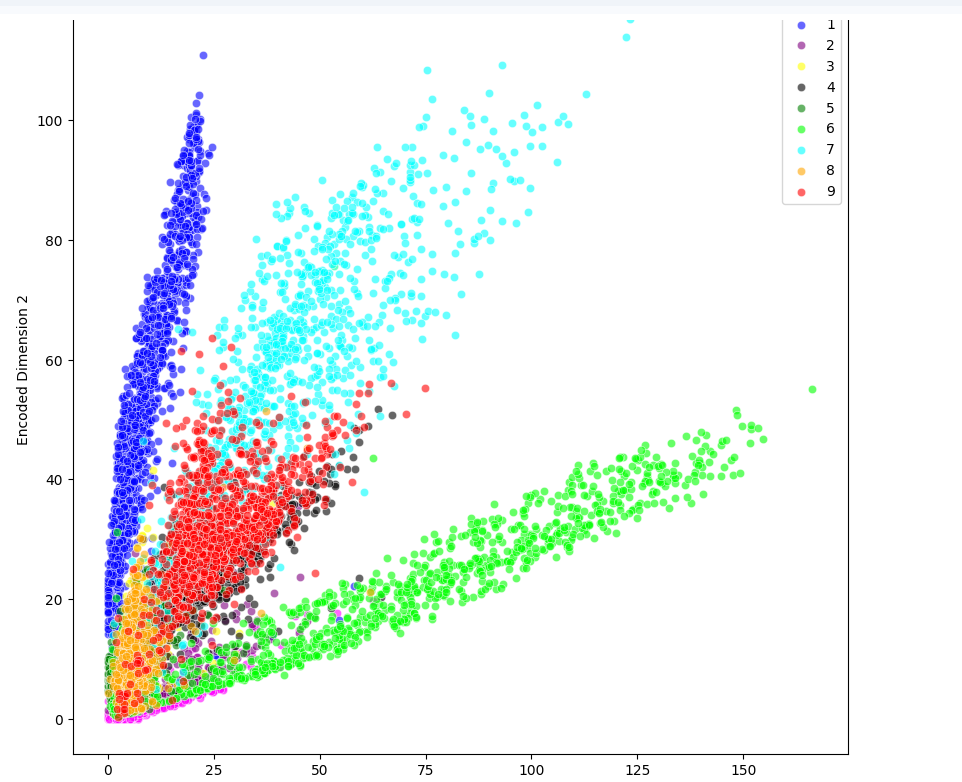

La siguiente figura captura la pregunta sobre que dígito va en el hueco entre el 1 y el 7

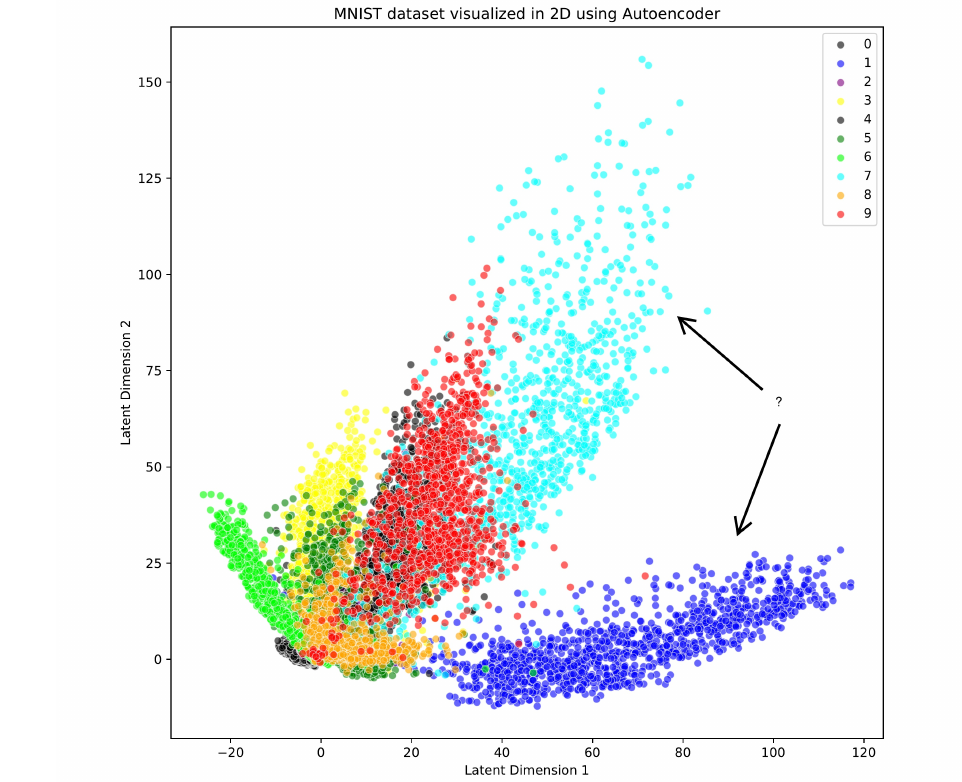

Para la interpolación sea suave el VAE se diseña en un espacio continuo. El espacio latente $z$ es continuo. Sobre este espacio continuo se muestrea para obtener objetos nuevos.  En espacio latente se generan dos vectores uno con la media y el otro con la desviación estandard ($\log \sigma²)$

Explicamos el algoritmo, inicialmente mediante un diagrama.
Figura siguiente.

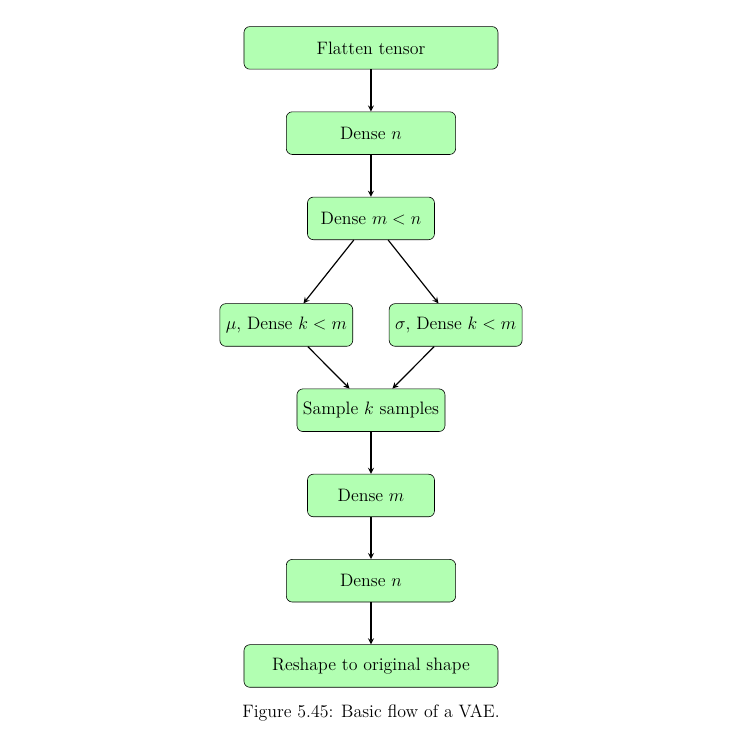

Por ejemplo asumimos las siguientes variables estocásticas
$X_1, X_2, \cdots, X_n$ a cada una de estas variables les asignamos media y desviación estandard. Asumimos un modelo MLP, y

$$\mu_i = W_\mu X_i + b_\mu $$
$$\log \sigma_i² = W_\sigma X_i + b_\sigma $$
En vez de $\sigma$ se observa que usamos $\log \sigma_i²$.
La razón es que $\sigma_i²$ es siempre positivo (o cero) y las redes neuronales funcionan mejor con nodos positivos y negativos.  A partir de $\log \sigma²$ se puede facilmente reconstruir

$$\sigma = \exp \left ( \frac12 \log ( \sigma² )     \right )  $$

Una de las razones por las cuales los VAE son ventajosos es por que mintras los vanilla AE usan punto, los VAE usan una nube Gaussiana (esto suaviza la interpolación). La Figura 5.46 ilustra esto.



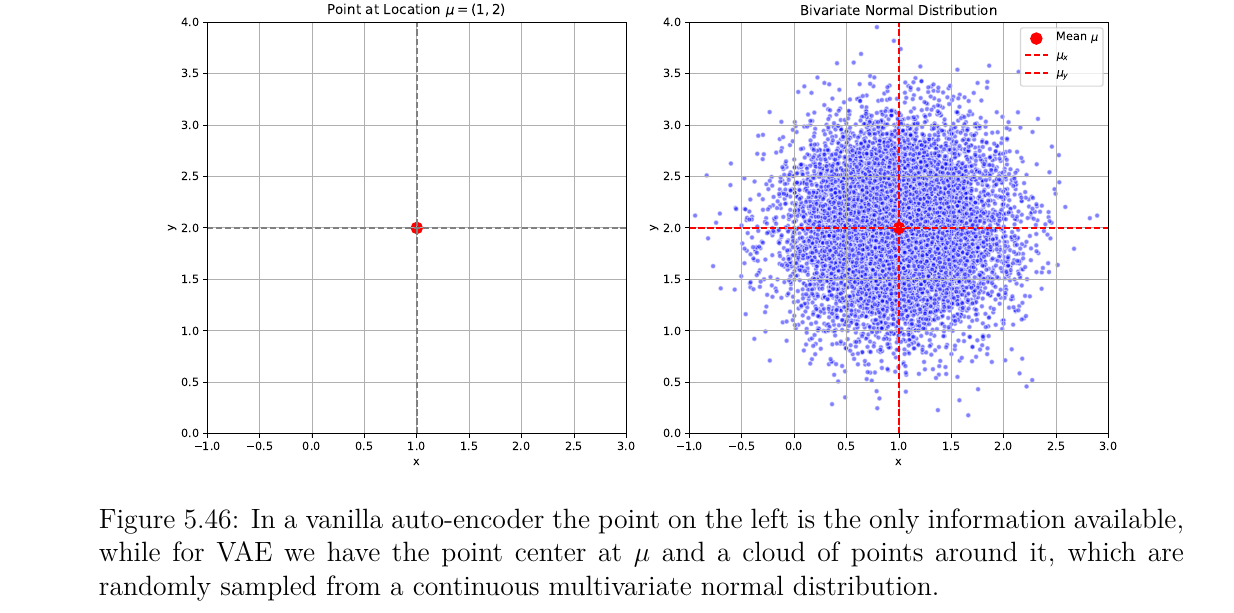

## Lenguaje matemático:
En teoría Bayesiana existe el concepto del **prior** (antes). Matemáticamente al prior lo llamamos $p(z)$.
Este **prior** (anterior) indica la probabilidad en el espacio latente $z$. También existe en la teoría Bayesiana el **posterior** (posterior) este matemáticamente se expresa mediante la fórmula $p(z | x)$.